# **PRÁCTICA 2: AUTOENCODERS - Parte 3: Variacionales**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 4ª curso del Grado Ciencia de Datos

## **Ejercicio 1: Modifica la arquitectura para que admita la base de datos cifar10 y una dimensión del dominio latente de 20 (10 para las medias y 10 para las desviaciones estándar)**

#### Librerías, datos y funciones necesarias

<p align="justify">Comenzamos cargando los datos</p>

In [86]:
from keras.datasets import cifar10
import numpy as np 

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 3])
x_test = np.reshape(x_test, [-1, image_size, image_size, 3])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

<p align="justify">Definimos los parámetros necesarios</p>

In [87]:
# Parámetros de la red
input_shape = (image_size, image_size, 3) 
kernel_size = 4 
filters = 10 
latent_dim = 10

# Parámetros de entrenamiento
batch_size = 250 # cambio de 128 a 250
epochs = 30

#### Encoder

<p align="justify">El siguiente código crea un modelo para el codificador. Al principio, las capas del modelo se crean</p>

In [88]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Conv2D, Flatten, Lambda

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2): 
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2, 
               padding='same')(x)

In [89]:
# shape info needed to build decoder model
from tensorflow.keras import backend as K
shape = K.int_shape(x)
print(shape) # CAMBIO antes (None, 8, 8, 64)

(None, 8, 8, 40)


In [90]:
# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(20, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [91]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [92]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
# Lambda funcion para hacer wrapping 
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

<p align="justify">Después de construir y conectar todas las capas, el siguiente paso es construir el modelo utilizando la tensorflow.keras.Model especificando los tensores de entrada y salida de acuerdo con la siguiente línea:</p>

In [93]:
# instantiate encoder model
from tensorflow.keras.models import Model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

<p align="justify">Para imprimir un resumen de la arquitectura del codificador, usaremos encoder.summary(). La salida está debajo. Esta red no es grande y puede aumentar la cantidad de neuronas en la capa densa nombrada, encoder_dense_1 pero solo usé 300 neuronas para evitar tomar mucho tiempo entrenando la red.</p>

In [94]:
#encoder.summary()
#plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

Después de construir el codificador, lo siguiente es trabajar en el decodificador.

#### Decoder

In [96]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2): 
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
#decoder.summary()
#plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

#### VAE

In [97]:
from tensorflow.keras.losses import mse, binary_crossentropy

# Cogemos la tercera salida del encoder, i.e. z
salida_enc = encoder(inputs)[2]
outputs = decoder(salida_enc)
vae = Model(inputs, outputs, name='vae')
# VAE loss = rec_loc + kl_loss
# ELBO: https://xyang35.github.io/2017/04/14/variational-lower-bound/

# rec_loc
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
# reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss = reconstruction_loss * image_size * image_size

# kl_loss
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

# VAE loss
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compilar modelo con la nueva loss
vae.compile(optimizer='rmsprop')
#vae.summary()
#plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

#### Entrenamos

In [98]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_cnn_mnist.h5')

Epoch 1/30
200/200 [==============================] - 4s 12ms/step - loss: 59.8111 - val_loss: 56.0269
Epoch 2/30
200/200 [==============================] - 2s 10ms/step - loss: 51.6150 - val_loss: 53.6281
Epoch 3/30
200/200 [==============================] - 2s 10ms/step - loss: 48.1363 - val_loss: 46.9335
Epoch 4/30
200/200 [==============================] - 2s 10ms/step - loss: 45.9886 - val_loss: 45.6927
Epoch 5/30
200/200 [==============================] - 2s 10ms/step - loss: 44.4767 - val_loss: 43.8544
Epoch 6/30
200/200 [==============================] - 2s 10ms/step - loss: 43.3341 - val_loss: 43.0953
Epoch 7/30
200/200 [==============================] - 2s 10ms/step - loss: 42.5345 - val_loss: 42.5393
Epoch 8/30
200/200 [==============================] - 2s 10ms/step - loss: 41.9617 - val_loss: 41.9134
Epoch 9/30
200/200 [==============================] - 2s 10ms/step - loss: 41.4890 - val_loss: 41.2782
Epoch 10/30
200/200 [==============================] - 2s 10ms/step - los

#### Recostrucción

313/313 [==============================] - 1s 3ms/step


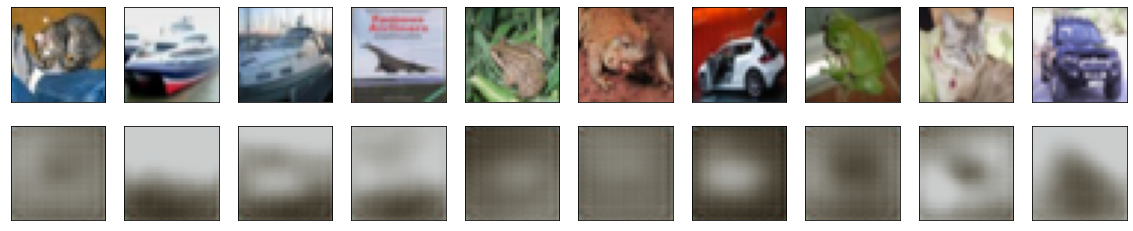

In [99]:
import matplotlib.pyplot as plt
decoded_imgs = vae.predict(x_test)
n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruccion
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()